<a href="https://colab.research.google.com/github/DataJenius/NLPEncodingExperiment/blob/main/python/NLPEncodingExperiment_custom768.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#######################################################################################################
# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()

Finished!


In [2]:
###########################################
# load all dependencies
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from stepbystep.v4 import StepByStep

from google.colab import files

In [8]:
######################################################################################
# our one-hot encoded data is on github
all_files = ['https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group1A.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group1B.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group2A.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group2B.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group3A.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group3B.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group4A.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group4B.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group5A.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom768/custom_encoded768_group5B.csv']
# concat into a single dataframe and shuffle the contents
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_all_data   = pd.concat(df_from_each_file, ignore_index=True)
df_all_data = df_all_data.sample(frac=1).reset_index(drop=True)

# make sure we loaded what we think we did
print(df_all_data.head())
print(df_all_data.shape)

   msg_id  token_count  my_group my_role  label      dim1      dim2      dim3  \
0    9370           16         2   train      0 -0.008082  0.001161  0.000775   
1   41515           51         3   train      1 -0.008588 -0.005160  0.000241   
2    8351           13         5    test      0 -0.008351  0.001011  0.001953   
3   10836           32         1   train      0 -0.008077 -0.000908  0.000468   
4   24419           27         5    test      1 -0.008454 -0.002397  0.000471   

       dim4      dim5  ...    dim759    dim760    dim761    dim762    dim763  \
0  0.005845  0.000990  ...  0.001229 -0.000085  0.000382  0.001474  0.000392   
1  0.000481 -0.002967  ... -0.001231 -0.002717  0.003446 -0.002939  0.000110   
2  0.006415 -0.000787  ...  0.001648 -0.000707  0.001044  0.000233 -0.000596   
3  0.005069 -0.000192  ...  0.000650 -0.000067 -0.000817 -0.000590  0.000050   
4  0.003079 -0.002115  ...  0.001153 -0.000138 -0.000153 -0.000651 -0.000058   

     dim764    dim765    dim766 

In [9]:
######################################################################################
# our data is already split into 5 groups, encoded and fully labelled

# setup this experiment
test_input_method = 'custom (768)'
print(test_input_method+" loading data...")

# split into val/test/train based on validation group 
df_train = df_all_data.loc[df_all_data['my_group'].isin([1,2,3])]
df_val = df_all_data.loc[df_all_data['my_group'] == 4]
df_test = df_all_data.loc[df_all_data['my_group'] == 5]

print("\n\ntrain - groups ",df_train['my_group'].unique())
print(df_train.head())
print("\n\nval - group ",df_val['my_group'].unique())
print(df_val.head())
print("\n\ntest - group ",df_test['my_group'].unique())
print(df_test.head())

# extract our labels into tensors 
train_labels_tensor = torch.as_tensor(df_train['label'].to_numpy().reshape(-1, 1)).float()
val_labels_tensor = torch.as_tensor(df_val['label'].to_numpy().reshape(-1, 1)).float()
test_labels_tensor = torch.as_tensor(df_test['label'].to_numpy().reshape(-1, 1)).float()
print("\n\nLabel Tensors:")
print("train - ",train_labels_tensor.shape)
print("val - ",val_labels_tensor.shape)
print("test - ",test_labels_tensor.shape)


# extract our features into tensors 
df_train_features = df_train.loc[:, ~df_train.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
train_features_tensor = torch.as_tensor(df_train_features.to_numpy()).float()
df_val_features = df_val.loc[:, ~df_val.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
val_features_tensor = torch.as_tensor(df_val_features.to_numpy()).float()
df_test_features = df_test.loc[:, ~df_test.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
test_features_tensor = torch.as_tensor(df_test_features.to_numpy()).float()
print("\n\nFeature Tensors:")
print("train - ",train_features_tensor.shape)
print("val - ",val_features_tensor.shape)
print("test - ",test_features_tensor.shape)


custom (768) loading data...


train - groups  [2 3 1]
   msg_id  token_count  my_group my_role  label      dim1      dim2      dim3  \
0    9370           16         2   train      0 -0.008082  0.001161  0.000775   
1   41515           51         3   train      1 -0.008588 -0.005160  0.000241   
3   10836           32         1   train      0 -0.008077 -0.000908  0.000468   
5   32274          102         2   train      1 -0.008704 -0.003202  0.001194   
7   21677           37         2   train      1 -0.007301 -0.002614 -0.000210   

       dim4      dim5  ...    dim759    dim760    dim761    dim762    dim763  \
0  0.005845  0.000990  ...  0.001229 -0.000085  0.000382  0.001474  0.000392   
1  0.000481 -0.002967  ... -0.001231 -0.002717  0.003446 -0.002939  0.000110   
3  0.005069 -0.000192  ...  0.000650 -0.000067 -0.000817 -0.000590  0.000050   
5 -0.001684 -0.001683  ... -0.000187  0.000351  0.000215  0.000843 -0.000626   
7  0.002470 -0.001494  ...  0.001636  0.001419  0.003541 -

In [10]:
######################################################################################
# build a TensorDataset containing ALL data points for train/val
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)

# build a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)
print(train_loader)
print(val_loader)

In [11]:
###############################################################################################
# use same model structure, just change embeddings into this one-hot input instead
torch.manual_seed(42)

# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/ 
model = nn.Sequential(
    nn.Linear(768, 1) 
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# get details about the model
def count_all_parameters(model):
    return sum(p.numel() for p in model.parameters())
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_all_parameters(model)
num_params_train = count_trainable_parameters(model)
print(model)
print(num_params, "total params")
print(num_params_train, "trainable params")

Sequential(
  (0): Linear(in_features=768, out_features=1, bias=True)
)
769 total params
769 trainable params


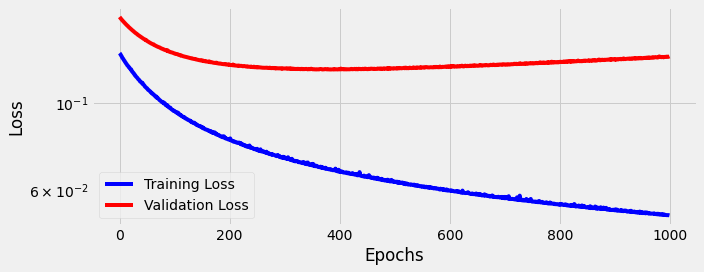

In [14]:
###############################################################################################
# train the model - only takes about 10s for 20 epochs, 1m for 100 epochs
sbs_oh = StepByStep(model, loss_fn, optimizer)
sbs_oh.set_loaders(train_loader, val_loader)
sbs_oh.train(1000)

# plot loss over epochs
fig = sbs_oh.plot_losses()

In [15]:
##############################################################
# how well does this model do with data it has never seen?
sbs_oh.model.eval()
out = sbs_oh.model(test_features_tensor)

# record detailed predictions for this model
df_experiment_results = pd.DataFrame({'method': test_input_method,
                                      'params': num_params,
                                      'params_train': num_params_train, 
                                      'msg_id': df_test['msg_id'],
                                      'label': df_test['label'],
                                      'p_sigmoid': torch.sigmoid(out).squeeze().tolist()}) 
df_experiment_results['pred'] = np.where(df_experiment_results['p_sigmoid']>0.5, 1, 0)
df_experiment_results['correct'] = np.where(df_experiment_results['pred']==df_experiment_results['label'], 1, 0)
df_experiment_results['tp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==1), 1, 0)
df_experiment_results['fp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['tn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['fn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==1), 1, 0)

# calculate metrics
tp = df_experiment_results["tp"].sum()
fp = df_experiment_results["fp"].sum()
tn = df_experiment_results["tn"].sum()
fn = df_experiment_results["fn"].sum()
prec = tp/(tp+fp)
recall = tp/(tp+fn)

# show our metrics
print("ACC: ",df_experiment_results["correct"].mean())
print("Precision: ",prec)
print("Recall: ", recall)

# save results to local CSV
file_name = 'results_'+test_input_method+'.csv'
df_experiment_results.to_csv(file_name, index=False) 
files.download(file_name)
print("\n\n",df_experiment_results.head(10))

ACC:  0.9545
Precision:  0.954045954045954
Recall:  0.955


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



           method  params  params_train  msg_id  label  p_sigmoid  pred  \
2   custom (768)     769           769    8351      0   0.000049     0   
4   custom (768)     769           769   24419      1   0.964091     1   
8   custom (768)     769           769    2467      0   0.001703     0   
10  custom (768)     769           769   27047      1   0.928240     1   
13  custom (768)     769           769   21885      1   0.998847     1   
19  custom (768)     769           769   47229      1   0.999995     1   
21  custom (768)     769           769    9824      0   0.001076     0   
25  custom (768)     769           769   12091      0   0.032296     0   
28  custom (768)     769           769   41573      1   0.987460     1   
30  custom (768)     769           769   27417      1   0.999954     1   

    correct  tp  fp  tn  fn  
2         1   0   0   1   0  
4         1   1   0   0   0  
8         1   0   0   1   0  
10        1   1   0   0   0  
13        1   1   0   0   0  
19